In [1]:
import os
import sys
import json

import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

In [2]:
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [14]:
from src.preprocessing.normalization.functional_normalization import functional_normalize_by
from src.evaluation.evaluate_scores import evaluate_scores
from src.learning.parameter_tuning import ParamSearch
from config import ROOT_DIR, AUDIO_FUNCTIONALS_EGEMAPS_COLS
from src.visualization.plot_means import plot_means_and_stds
from src.utils.get_splits import get_splits
from src.visualization.histogram import plot_hist
from src.visualization.confusion_matrix import ConfusionMatrixCreator, plot_conf_mat
from src.visualization.prec_recall_curve import plot_prec_recall_curve, plot_auc_curve

In [4]:
AUDIO_VISUALIZATION_COLS = [
    'F0semitoneFrom27.5Hz_sma3nz_amean',
    'loudness_sma3_amean',
]

In [5]:
# paths
input_data = os.path.join(ROOT_DIR, "files/data/opensmile_functionals.csv")
output_data = os.path.join(ROOT_DIR, "files/out")

In [6]:
df = pd.read_csv(input_data, delimiter=";")

In [7]:
df

,Unnamed: 0,sttmnt_ID,Participant,Statement,Accuracy,Confidence_level,Confidence_type,Free_cued_recall,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,...,slopeUV0.500_sma3nz_amean,slopeUV500.1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,1,S2_w01_t1_s01.wav',1,1,1,100.0,1.0,1,34.36551,0.136942,...,-0.037406,-0.007398,0.227092,2.985075,2.431611,0.273750,0.273173,0.115000,0.064226,-36.21673
1,2,S2_w01_t1_s10.wav',1,10,1,NaN,NaN,1,25.96453,0.271193,...,-0.054731,-0.010005,0.174763,1.526718,2.695764,0.124286,0.097764,0.261667,0.420809,-40.86316
2,3,S2_w01_t1_s11.wav',1,11,1,NaN,NaN,1,28.89816,0.212653,...,-0.049107,-0.009912,0.145613,3.191489,2.964960,0.127273,0.110131,0.188182,0.153019,-40.07899
3,4,S2_w01_t1_s12.wav',1,12,1,NaN,NaN,1,27.56384,0.221763,...,-0.056503,-0.007487,0.166699,2.303263,3.100775,0.194375,0.149331,0.114667,0.099791,-37.72633
4,5,S2_w01_t1_s13.wav',1,13,1,100.0,1.0,1,28.47333,0.204346,...,-0.048038,-0.012770,0.127892,3.787879,3.333333,0.119231,0.131058,0.188182,0.110767,-40.21887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,3544,'S2_w09_t1_s67.wav',9,67,0,40.0,1.0,2,32.79814,0.099313,...,-0.062526,-0.012370,0.063130,1.960784,1.600000,0.285000,0.170660,0.320000,0.201618,-42.12679
3544,3545,'S2_w09_t1_s68.wav',9,68,0,40.0,1.0,2,26.07878,0.311368,...,-0.068615,-0.005863,0.131412,2.256944,0.525394,0.080000,0.056569,1.350000,1.910340,-46.44904
3545,3546,'S2_w09_t1_s07.wav',9,7,1,80.0,1.0,1,29.64281,0.148856,...,-0.049520,-0.009493,0.109803,2.551985,2.089269,0.176364,0.189941,0.294286,0.462865,-41.92608
3546,3547,'S2_w09_t1_s08.wav',9,8,1,100.0,1.0,1,27.60379,0.268069,...,-0.056958,-0.008350,0.166478,1.785714,2.004008,0.105000,0.096670,0.372000,0.463353,-42.42829


In [8]:
y = df["Accuracy"].values
x = df[AUDIO_FUNCTIONALS_EGEMAPS_COLS].values
participant = df["Participant"].values

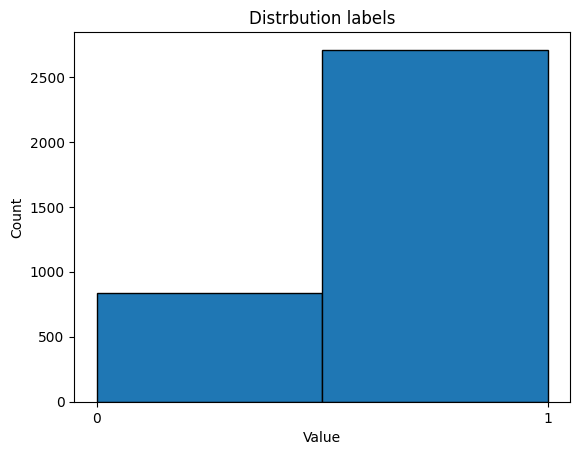

In [9]:
plot_hist(y, "labels")

## Normalization

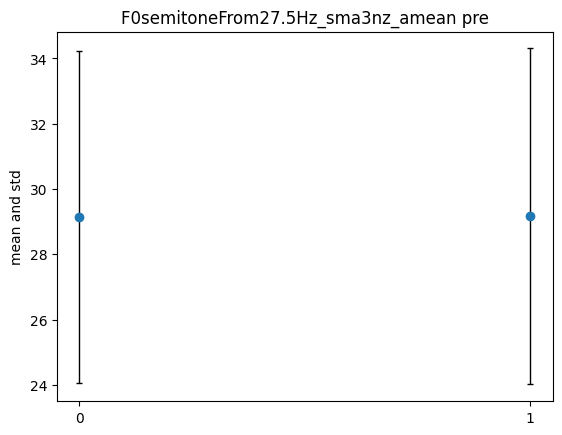

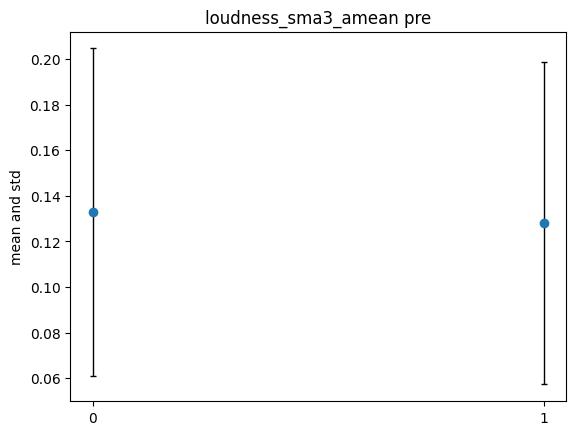

In [10]:
plot_means_and_stds(x, y, AUDIO_VISUALIZATION_COLS, "pre")

In [11]:
x = functional_normalize_by(x, participant, method="min_max")

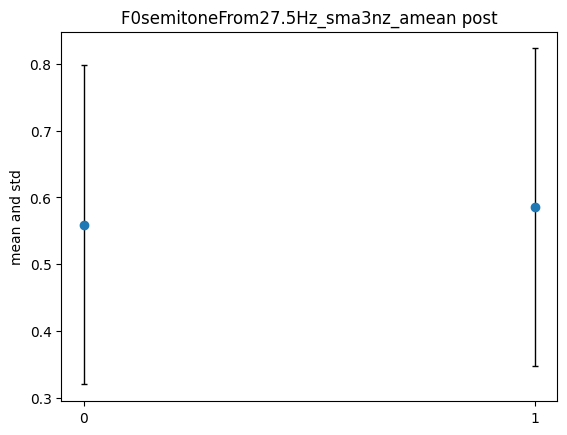

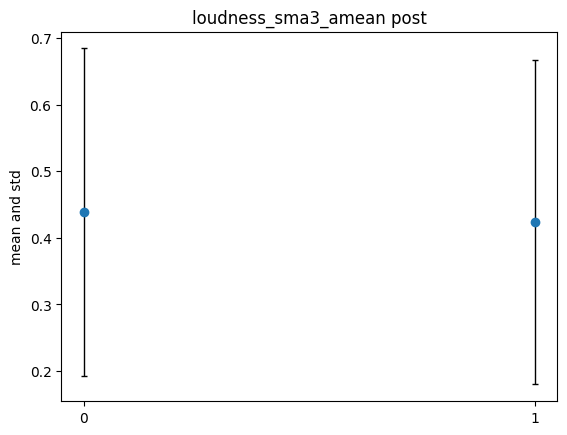

In [12]:
plot_means_and_stds(x, y, AUDIO_VISUALIZATION_COLS, "post")

# Parameter search, training and evaluation

In [15]:
def search_train_evaluate(x, y, parameter_search_scoring):
    print("Evaluation with {} scoring in parameter search".format(parameter_search_scoring))
    
    params_path = os.path.join(output_data, "best_params_" + parameter_search_scoring + ".json")
    
    print()

    ps = ParamSearch()
    clf = ps.param_search(x, y, parameter_search_scoring)
    clf.best_params_

    with open(params_path, "w") as outfile:
        # writing to json file
        json.dump(clf.best_params_, outfile)

    with open(params_path, 'r') as openfile:
        # Reading from json file
        best_params = json.load(openfile)
    
    print(best_params)
    svc = SVC(**best_params)
    print()
    evaluate_scores(x=x,
                    y=y,
                    clf=svc,
                    scoring_method="roc_auc")
    print()
    svc = SVC(**best_params)
    evaluate_scores(x=x,
                    y=y,
                    clf=svc,
                    scoring_method="accuracy")
    print()
    svc = SVC(**best_params)
    evaluate_scores(x=x,
                    y=y,
                    clf=svc,
                    scoring_method="f1_macro")

    splits = get_splits(x, y)
    y_pred = cross_val_predict(svc, x, y, cv=splits)

    plot_hist(y_pred, "predictions")

    report = metrics.classification_report(y_true=y, y_pred=y_pred)
    print(report)
    
    splits = get_splits(x, y)
    conf_mat_creator = ConfusionMatrixCreator(clf=svc)
    conf_mat = conf_mat_creator.calculate_avg_conf_matrix(x, y, splits)
    plot_conf_mat(conf_mat)
    
    svc = SVC(**best_params, probability=True)
    plot_auc_curve(svc, x, y)
    
    plot_prec_recall_curve(svc, x, y)

### Parameter search with AUC scoring

Evaluation with roc_auc scoring in parameter search

{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}

printing roc_auc measures
avg (train): 0.8078479246470351
std (train): 0.004291630641423225
avg (validation): 0.6294530945426859
std (validation): 0.022508037216873583

printing accuracy measures
avg (train): 0.7022966627372043
std (train): 0.00721348586797871
avg (validation): 0.6135807227000933
std (validation): 0.01593171051163849

printing f1_macro measures
avg (train): 0.6647386200350384
std (train): 0.0052663803401243195
avg (validation): 0.5634554587730671
std (validation): 0.017325753120825755


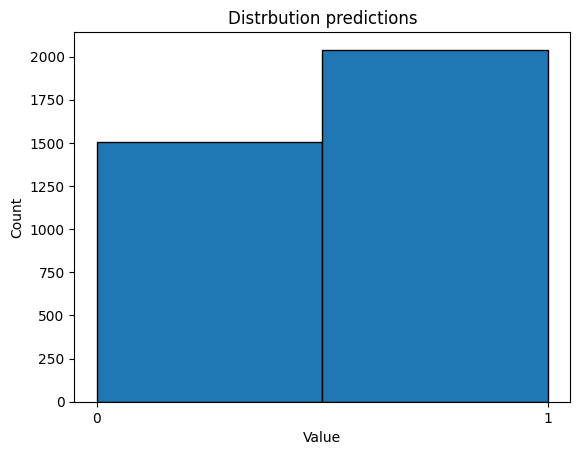

              precision    recall  f1-score   support

           0       0.32      0.58      0.42       839
           1       0.83      0.62      0.71      2709

    accuracy                           0.61      3548
   macro avg       0.58      0.60      0.56      3548
weighted avg       0.71      0.61      0.64      3548



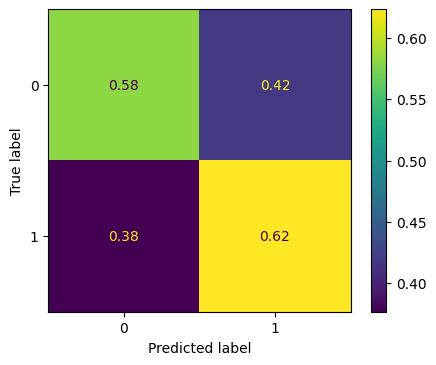

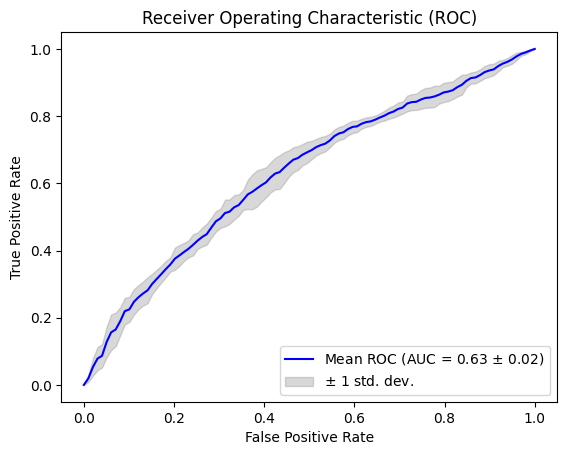

In [18]:
search_train_evaluate(x, y, "roc_auc")

### Parameter search with Accuracy scoring 

Evaluation with accuracy scoring in parameter search

{'C': 5, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
{'C': 5, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}

printing roc_auc measures
avg (train): 1.0
std (train): 0.0
avg (validation): 0.604892720680281
std (validation): 0.014216448575109893

printing accuracy measures
avg (train): 1.0
std (train): 0.0
avg (validation): 0.7587369633882278
std (validation): 0.0016869904662969038

printing f1_macro measures
avg (train): 1.0
std (train): 0.0
avg (validation): 0.4601678232632388
std (validation): 0.011850310657832392


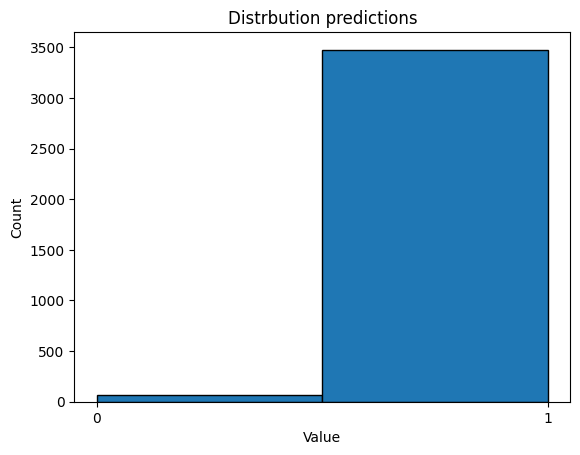

              precision    recall  f1-score   support

           0       0.38      0.03      0.06       839
           1       0.77      0.98      0.86      2709

    accuracy                           0.76      3548
   macro avg       0.57      0.51      0.46      3548
weighted avg       0.68      0.76      0.67      3548



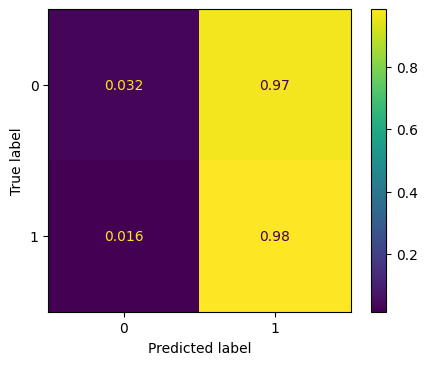

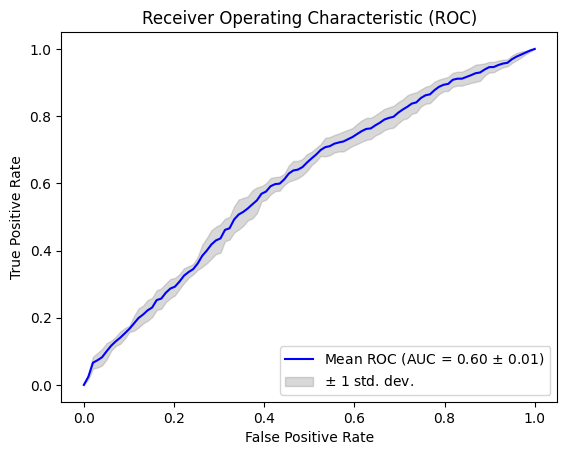

In [16]:
search_train_evaluate(x, y, "accuracy")

### Parameter search with F1_macro scoring 

Evaluation with f1_macro scoring in parameter search

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'sigmoid'}
{'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'sigmoid'}

printing roc_auc measures
avg (train): 0.6149751658585568
std (train): 0.005461198640561774
avg (validation): 0.613213570612792
std (validation): 0.020365919905935198

printing accuracy measures
avg (train): 0.625563175353062
std (train): 0.015173747496199107
avg (validation): 0.6220365919068713
std (validation): 0.031616361226108114

printing f1_macro measures
avg (train): 0.5574379221334718
std (train): 0.003202806282916512
avg (validation): 0.5559837227832495
std (validation): 0.022541789120280317


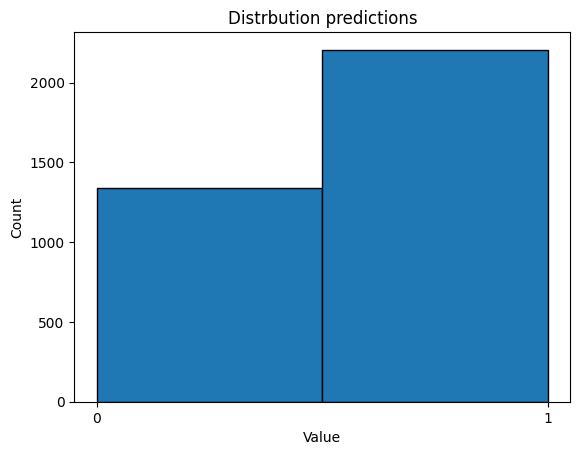

              precision    recall  f1-score   support

           0       0.31      0.50      0.39       839
           1       0.81      0.66      0.73      2709

    accuracy                           0.62      3548
   macro avg       0.56      0.58      0.56      3548
weighted avg       0.69      0.62      0.65      3548



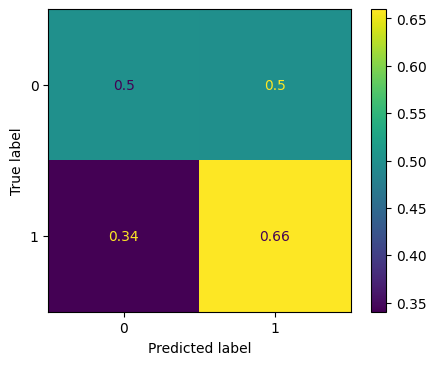

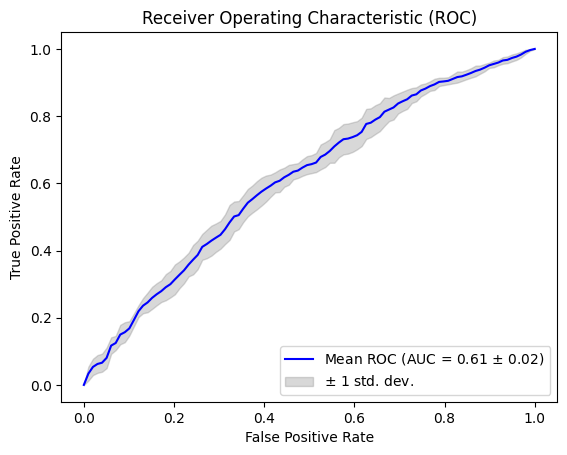

In [17]:
search_train_evaluate(x, y, "f1_macro")

## Precision Recall Curves

In [ ]:
params_path = os.path.join(output_data, "best_params_" + "auc_roc" + ".json")

with open(params_path, 'r') as openfile:
    # Reading from json file
    best_params = json.load(openfile)

In [ ]:
best_params

{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}

In [ ]:
svc = SVC(**best_params, probability=True)

y_scores = cross_val_predict(svc, x, y, cv=5, method='predict_proba')[:, 1]

### Postive label as 1

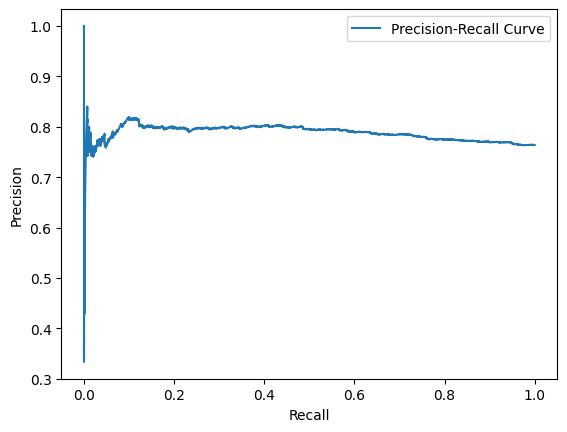

In [ ]:
precision, recall, thresholds = precision_recall_curve(y, y_scores)

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Postive label as 0

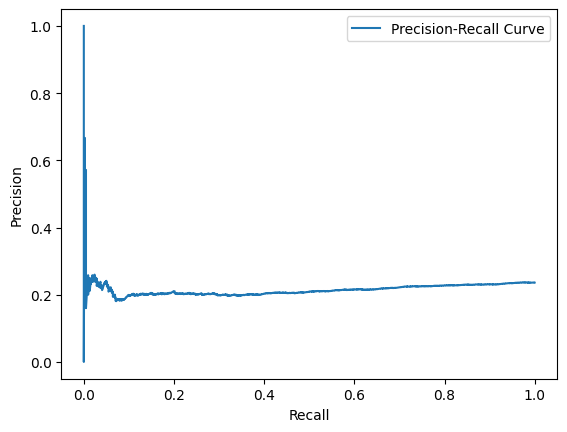

In [ ]:
precision, recall, thresholds = precision_recall_curve(y, y_scores, pos_label=0)

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()